**7/9:** Able to get Google News data using API

**7/10:** Read articles about models using RNN & LSTM to predict stock/cryptocurrency prices

**7/11:** Applied an existing model to Bitcoin daily price data and got F1 score around 0.52; no improvement with larger historical data


## Google News data

Use the Google News API 

`72bc383e0bd44a5cb0997c468f7e0a2e`

In [0]:
import requests
import json
import codecs
import csv
import pandas as pd

In [0]:
file = codecs.open('movie.json', 'w', encoding='utf-8')
#API
API_KEY = '72bc383e0bd44a5cb0997c468f7e0a2e'
url = 'https://newsapi.org/v2/everything?q=bitcoin&apiKey='+API_KEY
#
start=5
count=25
r = requests.get(url, params={'start': start, 'count': count})
r.encoding='UTF_8'
content=r.json()
file.write(json.dumps(content, ensure_ascii=False))


In [210]:
csvfile = open('results_1.csv', 'w')
header = ['Name','Title','description','url','publishedAt']
# filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
filewriter = csv.writer(csvfile)
filewriter.writerow(header)

40

In [0]:
# with open('movie.json') as json_data:
#     data = json.load(json_data,) 
# 
# for item in data["articles"]:
#   print(item["source"]["name"])
#   print(item["title"])
#   print(item["description"])
#   print(item["url"])
#   print(item["publishedAt"])
#   print("\n")

In [0]:
with open('movie.json') as json_data:
    data = json.load(json_data,) 

for item in data["articles"]:
  temp = []
  temp.append(item["source"]["name"])
  temp.append(item["title"])
  temp.append(item["description"])
  temp.append(item["url"])
  temp.append(item["publishedAt"])
  filewriter.writerow(temp)


In [217]:
from textblob import TextBlob
text = TextBlob("Today I went to class and I was not happy")
print(text.sentiment.polarity)
print(text.sentiment.subjectivity)

-0.4
1.0


## Bitcoin Price Prediction


### Get Bitcoin Historical Data

In [0]:
import re
import requests
from bs4 import BeautifulSoup

Get Bitcoin historical data from CoinMarketCap. 

We can modify the start and end date in the link in needed in the future.

In [0]:
r = requests.get('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150101&end=20190711')

In [0]:
soup = BeautifulSoup(r.text, 'lxml')

In [0]:
divs = soup.find_all(class_ = 'table')

In [190]:
import csv
csvfile = open('results.csv', 'w')
header = ['Open','High','Low','Close', 'Volume', 'Market Cap'] # not written to csv
filewriter = csv.writer(csvfile)
filewriter.writerow(header)

39

In [0]:
entries = soup.find_all('td')
temp = []
# hhh = []
for i in range(len(entries)):
  
  if i % 7 == 0:
    if i != 0:
      filewriter.writerow(temp)
      temp = []
#     temp.append(i//7)
  else:
    temp.append(entries[i].text)
#   hhh.append(entries[i].text)

# print(hhh)

### Model

Adopted code from Jerry Wei

In [66]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

Using TensorFlow backend.


#### Load Data

In [0]:
def load_data(filename, sequence_length):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    X_train -- A tensor of shape (2400, 49, 35) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2400,) that will be inputed into the model to train it
    X_test -- A tensor of shape (267, 49, 35) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (267,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (267,) that represents the price of bitcoin the day before each Y_test value
    unnormalized_bases -- A tensor of shape (267,) that will be used to get the true prices from the normalized ones
    window_size -- An integer that represents how many days of X values the model can look at at once
    """
    #Read the data file
#     raw_data = pd.read_csv(filename, dtype = float).values
      
    raw_data = filename.values
    #Change all zeros to the number before the zero occurs
    for x in range(0, raw_data.shape[0]):
        for y in range(0, raw_data.shape[1]):
            if(raw_data[x][y] == 0):
                raw_data[x][y] = raw_data[x-1][y]
    
    #Convert the file to a list
    data = raw_data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
#     print("???")
#     print(dr.shape)
    #Keeping the unnormalized prices for Y_test
    #Useful when graphing bitcoin price over time later
    start = 1360 # NEED TO CHANGE, DEPEND ON NUMBER OF DATA
    end = int(dr.shape[0] + 1)
#     unnormalized_bases = d0[start:end,0:1,20]
    unnormalized_bases = d0[start:end,0:1,4]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
#     Y_train = Y_train[:, 20]
    Y_train = Y_train[:, 3]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
#     Y_test = Y_test[:, 20]
    Y_test = Y_test[:, 3]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
#     Y_daybefore = Y_daybefore[:, 20]
    Y_daybefore = Y_daybefore[:, 3]

    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

In [0]:
def load_data2(filename, sequence_length):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    X_train -- A tensor of shape (2400, 49, 35) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2400,) that will be inputed into the model to train it
    X_test -- A tensor of shape (267, 49, 35) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (267,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (267,) that represents the price of bitcoin the day before each Y_test value
    unnormalized_bases -- A tensor of shape (267,) that will be used to get the true prices from the normalized ones
    window_size -- An integer that represents how many days of X values the model can look at at once
    """
    #Read the data file
    raw_data = pd.read_csv(filename, dtype = float).values
    
    #Change all zeros to the number before the zero occurs
    for x in range(0, raw_data.shape[0]):
        for y in range(0, raw_data.shape[1]):
            if(raw_data[x][y] == 0):
                raw_data[x][y] = raw_data[x-1][y]
    
    #Convert the file to a list
    data = raw_data.tolist()
    
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    d0 = np.array(result)
    dr = np.zeros_like(d0)
    dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Keeping the unnormalized prices for Y_test
    #Useful when graphing bitcoin price over time later
    start = 2400
    end = int(dr.shape[0] + 1)
    unnormalized_bases = d0[start:end,0:1,20]
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:, :-1]
    Y_train = training_data[:, -1]
    Y_train = Y_train[:, 20]
    
    #Testing data
    X_test = dr[int(split_line):, :-1]
    Y_test = dr[int(split_line):, 49, :]
    Y_test = Y_test[:, 20]

    #Get the day before Y_test's price
    Y_daybefore = dr[int(split_line):, 48, :]
    Y_daybefore = Y_daybefore[:, 20]
    
    #Get window size and sequence length
    sequence_length = sequence_length
    window_size = sequence_length - 1 #because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

#### Building the Model

In [0]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    """
    Initializes and creates the model to be used
    
    Arguments:
    window_size -- An integer that represents how many days of X_values the model can look at at once
    dropout_value -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((window_size*2), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

#### Training the Model

In [0]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2400, 49, 35) that represents the x values of the training data
    Y_train -- A tensor of shape (2400,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 1024
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

#### Testing the Model

In [0]:
def test_model(model, X_test, Y_test, unnormalized_bases):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (267, 49, 35) that represents the x values of the testing data
    Y_test -- A tensor of shape (267,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (267,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (267,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (267,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (267,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    y_predict = model.predict(X_test)

    #Create empty 2D arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

#### Evaluating Change in Price

In [0]:
def price_change(Y_daybefore, Y_test, y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    Y_daybefore -- A tensor of shape (267,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267,) that represents the normalized y values of the model's predictions
    
    Returns:
    Y_daybefore -- A tensor of shape (267, 1) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    delta_predict -- A tensor of shape (267, 1) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (267, 1) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

#### Process the Percent Change in Price

In [0]:
def binary_price(delta_predict, delta_real):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (267, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (267, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0    

    return delta_predict_1_0, delta_real_1_0

#### Comparing Predictions and Real Data

In [0]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

#### Calculating Statistics

In [0]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    """
    Calculate various statistics to assess performance
    
    Arguments:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267, 1) that represents the normalized y values of the model's predictions
    
    Returns:
    precision -- How often the model gets a true positive compared to how often it returns a positive
    recall -- How often the model gets a true positive compared to how often is hould have gotten a positive
    F1 -- The weighted average of recall and precision
    Mean Squared Error -- The average of the squares of the differences between predicted and real values
    """
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

#### Putting Together

In [0]:
raw_data = pd.read_csv("./results.csv")

raw_data['Volume'] = raw_data['Volume'].str.replace(",","").astype(float)
raw_data['Market Cap'] = raw_data['Market Cap'].str.replace(",","").astype(float)

In [199]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data(raw_data, 50)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (Y_daybefore.shape)
print (unnormalized_bases.shape)
print (window_size)

(1360, 49, 6)
(1360,)
(151, 49, 6)
(151,)
(151,)
(151, 1)
49


In [200]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load_data2("./Bitcoin Data.csv", 50)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print (Y_daybefore.shape)
print (unnormalized_bases.shape)
print (window_size)

(2400, 49, 35)
(2400,)
(267, 49, 35)
(267,)
(267,)
(267, 1)
49


Initialize model

In [201]:
model = initialize_model(window_size, 0.2, 'linear', 'mse', 'adam')
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 49, 98)            33320     
_________________________________________________________________
dropout_5 (Dropout)          (None, 49, 98)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 196)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 99        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

Train model

In [202]:
model, training_time = fit_model(model, X_train, Y_train, 1024, 100, .05)

#Print the training time
print ("Training time", training_time, "seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2280 samples, validate on 120 samples
Epoch 1/100
2280/2280 [==============================] - 17s 7ms/step - loss: 2.7777 - val_loss: 0.2265
Epoch 2/100
2280/2280 [==============================] - 11s 5ms/step - loss: 2.0308 - val_loss: 0.5228
Epoch 3/100
2280/2280 [==============================] - 11s 5ms/step - loss: 1.7362 - val_loss: 0.4147
Epoch 4/100
2280/2280 [==============================] - 11s 5ms/step - loss: 1.3798 - val_loss: 0.2735
Epoch 5/100
2280/2280 [==============================] - 11s 5ms/step - loss: 1.2066 - val_loss: 0.3313
Epoch 6/100
2280/2280 [==============================] - 10s 5ms/step - loss: 1.0155 - val_loss: 0.3401
Epoch 7/100
2280/2280 [==============================] - 10s 5ms/step - loss: 0.8329 - val_loss: 0.1501
Epoch 8/100
2280/2280 [==============================] - 10s 5ms/step - loss: 0.6493 - val_loss: 0.0951
Epoch 9/100
2280/2280 [==============================] - 10s 5ms/step - loss: 0.5071 - val_loss: 0.0838
Epoch 10/100
2280

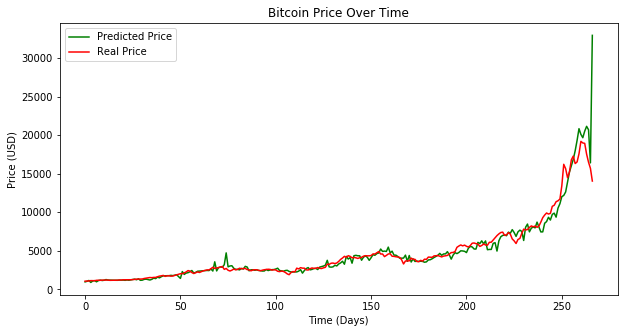

In [203]:
y_predict, real_y_test, real_y_predict, fig1 = test_model(model, X_test, Y_test, unnormalized_bases)

#Show the plot
plt.show(fig1)

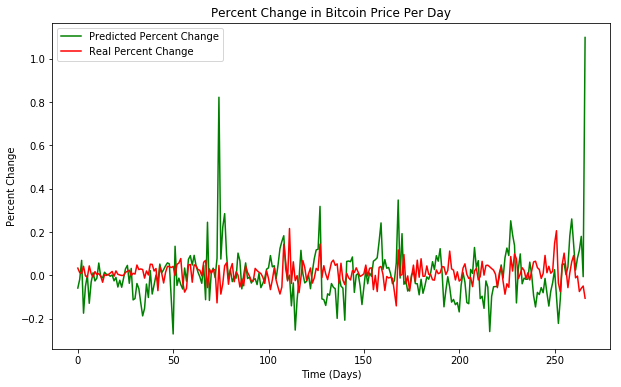

In [204]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)

#Show the plot
plt.show(fig2)

In [205]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict, delta_real)

print (delta_predict_1_0.shape)
print (delta_real_1_0.shape)

(267, 1)
(267, 1)


In [206]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 75
False positives: 47
True negatives: 52
False negatives: 93


In [207]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print ("Precision:", precision)
print ("Recall:", recall)
print ("F1 score:", F1)
print ("Mean Squared Error:", MSE)

Precision: 0.6147540983606558
Recall: 0.44642857142857145
F1 score: 0.5172413793103448
Mean Squared Error: 0.06960177451142743
